In [37]:
import sys
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper
img_path = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/'

In [16]:
csv = '/kaggle/input/segmentation-full-body-mads-dataset/df.csv'
data_dir = '/content/'
device = 'cuda'

epochs = 25
learning_rate = 0.003
image_size = 320
batch_size = 16

df = pd.read_csv(csv)
df.head()

,Unnamed: 0,images,masks,collages
0,0,images/HipHop_HipHop1_C0_00180.png,masks/HipHop_HipHop1_C0_00180.png,collages/HipHop_HipHop1_C0_00180.jpg
1,1,images/HipHop_HipHop1_C0_00225.png,masks/HipHop_HipHop1_C0_00225.png,collages/HipHop_HipHop1_C0_00225.jpg
2,2,images/HipHop_HipHop1_C0_00360.png,masks/HipHop_HipHop1_C0_00360.png,collages/HipHop_HipHop1_C0_00360.jpg
3,3,images/HipHop_HipHop1_C0_00405.png,masks/HipHop_HipHop1_C0_00405.png,collages/HipHop_HipHop1_C0_00405.jpg
4,4,images/HipHop_HipHop1_C0_00450.png,masks/HipHop_HipHop1_C0_00450.png,collages/HipHop_HipHop1_C0_00450.jpg


In [39]:
# Your base path
base_path = "/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/"

# Assuming df is your DataFrame
df = df.applymap(lambda x: base_path + str(x))


<ipython-input-39-07646527775b>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: base_path + str(x))


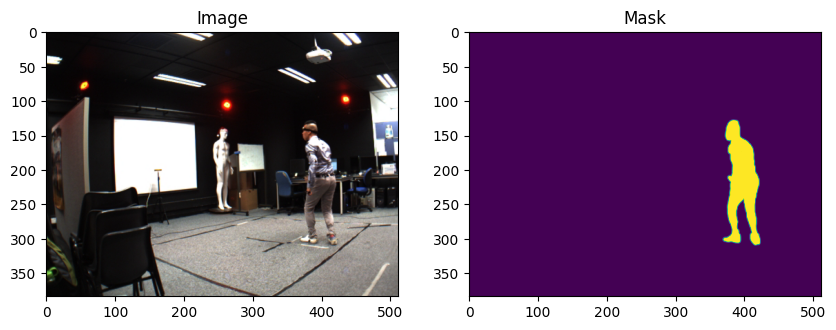

In [40]:
row = df.iloc[34]
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.set_title('Image')
ax1.imshow(image)
ax2.set_title('Mask')
ax2.imshow(mask)

In [41]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [42]:
import albumentations as A
def train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def val_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
  ])


In [43]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [44]:
trainset = SegmentationDataset(train_df, train_augs())
validset = SegmentationDataset(test_df, val_augs())

In [45]:
print("The size of the training dataset is: ", len(trainset))
print("The size of the validation dataset is: ", len(validset))

The size of the training dataset is:  953
The size of the validation dataset is:  239


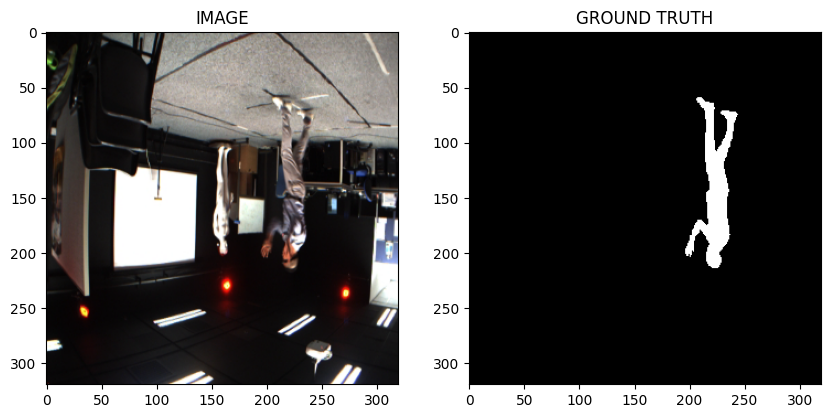

In [46]:
index = 21

image, mask = trainset[index]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0),cmap = 'gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0),cmap = 'gray')

In [47]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

print("The total  number of batches in train loader are: ", len(trainloader))
print("The total  number of batches in valid loader are: ", len(validloader))

The total  number of batches in train loader are:  60
The total  number of batches in valid loader are:  15


In [49]:
import torch as torch
import torch.nn as nn
from torchvision import models

class AttentionGate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )

        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )

        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * g
    

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DoubleConv, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers(x)


class Decoder(nn.Module):
    def __init__(self, up_in_channels, x_in_channels, kernel_size=3, padding=1, dropout=0):
        super(Decoder, self).__init__()

        self.upsample = nn.ConvTranspose2d(up_in_channels, up_in_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)

        up_out_channels = up_in_channels // 2
        self.attention_gate = AttentionGate([up_out_channels, x_in_channels], up_out_channels)
        in_channels = up_in_channels // 2 + x_in_channels
        out_channels = in_channels // 2

        self.layers = DoubleConv(in_channels, out_channels, kernel_size, padding)

    def forward(self, skip_connection, x):
        x = self.upsample(x)
        x = self.attention_gate(x, skip_connection)
        return self.layers(torch.cat([skip_connection, x], dim=1))


class AttenResUnet(nn.Module):
    def __init__(self):

        backbone = models.resnet34(pretrained=True)

        super(AttenResUnet, self).__init__()

        for param in backbone.parameters():
            param.requires_grad = False

        self.encoder0 = nn.Sequential(
                        backbone.conv1, 
                        backbone.bn1, 
                        backbone.relu
                        )
        
        self.maxpool = backbone.maxpool

        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

        self.middle = DoubleConv(512, 512)

        self.decoder0 = Decoder(512, 256)
        self.decoder1 = Decoder(256, 128)
        self.decoder2 = Decoder(128, 64)
        self.decoder3 = Decoder(64, 64)

        self.resize = nn.ConvTranspose2d(48, 16, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.final_layer = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            )


    def forward(self, x):
        a1 = self.encoder0(x)
        a1_pooled = self.maxpool(a1)
        a2 = self.encoder1(a1_pooled)
        a3 = self.encoder2(a2)
        a4 = self.encoder3(a3)
        a5 = self.encoder4(a4)

        mid = self.middle(a5)

        d1 = self.decoder0(a4, mid)
        d2 = self.decoder1(a3, d1)
        d3 = self.decoder2(a2, d2)
        d4 = self.decoder3(a1, d3)

        resized = self.resize(d4)
        final = self.final_layer(resized)

        return final

In [50]:
model = AttenResUnet().to(device)

# --- ⚙️ Loss and Optimizer ---
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- 🏋️ Training Loop ---
for epoch in range(10):  # Try 5 epochs to test
    model.train()
    epoch_loss = 0
    for imgs, masks in trainloader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        preds = model(imgs)
        loss = criterion(preds, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss/len(trainloader):.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.7013
Epoch [2/5], Loss: 0.6739
Epoch [3/5], Loss: 0.6711
Epoch [4/5], Loss: 0.6705
Epoch [5/5], Loss: 0.6699
Epoch [6/5], Loss: 0.6696
Epoch [7/5], Loss: 0.6693
Epoch [8/5], Loss: 0.6691
Epoch [9/5], Loss: 0.6690
Epoch [10/5], Loss: 0.6688


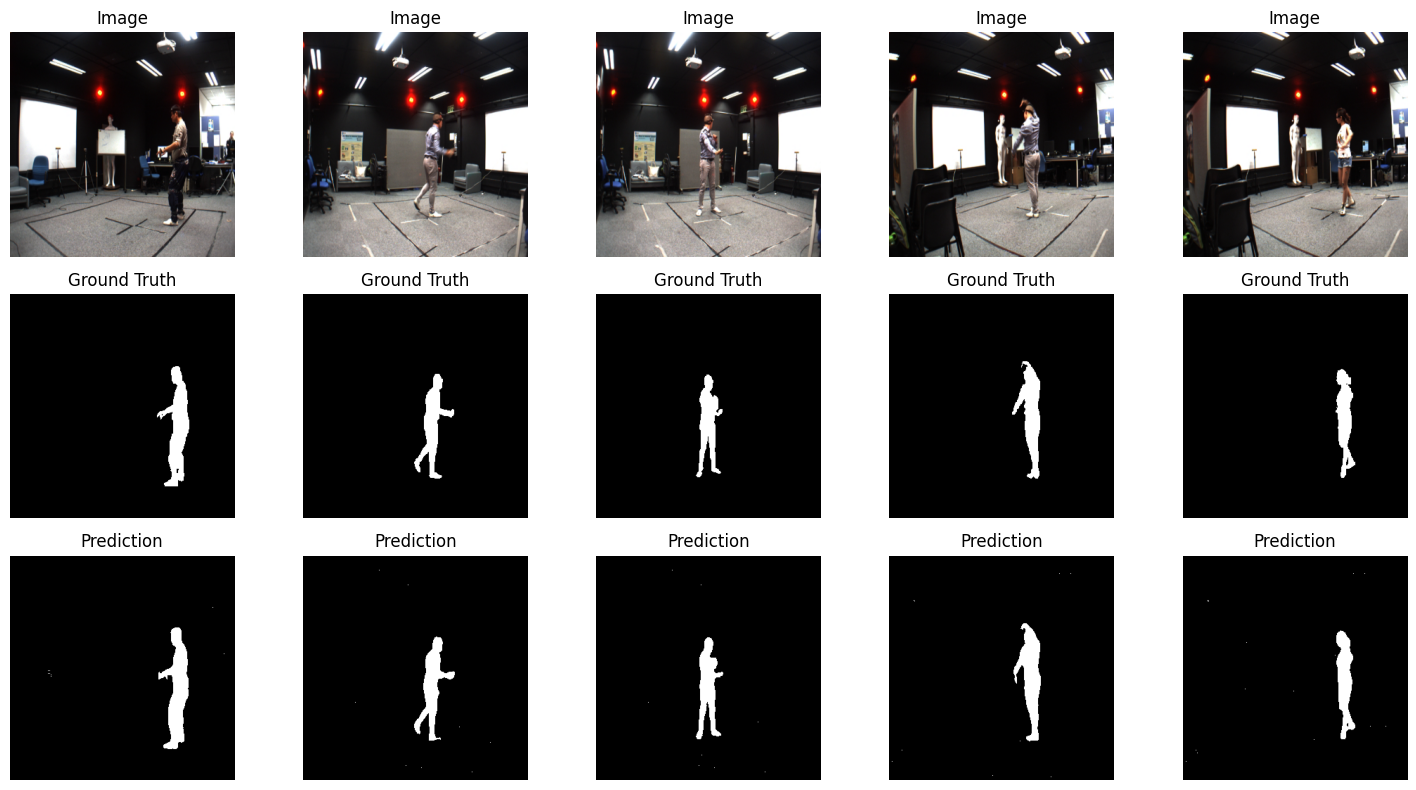

In [51]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(validloader))
    imgs = imgs.cuda()
    preds = torch.sigmoid(model(imgs)) > 0.5
    
    fig, axs = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        axs[0, i].imshow(imgs[i].cpu().permute(1, 2, 0))
        axs[1, i].imshow(masks[i].squeeze(0), cmap='gray')
        axs[2, i].imshow(preds[i].squeeze(0).cpu(), cmap='gray')
        axs[0, i].set_title("Image")
        axs[1, i].set_title("Ground Truth")
        axs[2, i].set_title("Prediction")
        for j in range(3): axs[j, i].axis('off')
    plt.tight_layout()
    plt.show()